# Часть 1

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


<ipython-input-2-c260d4cb9856>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)


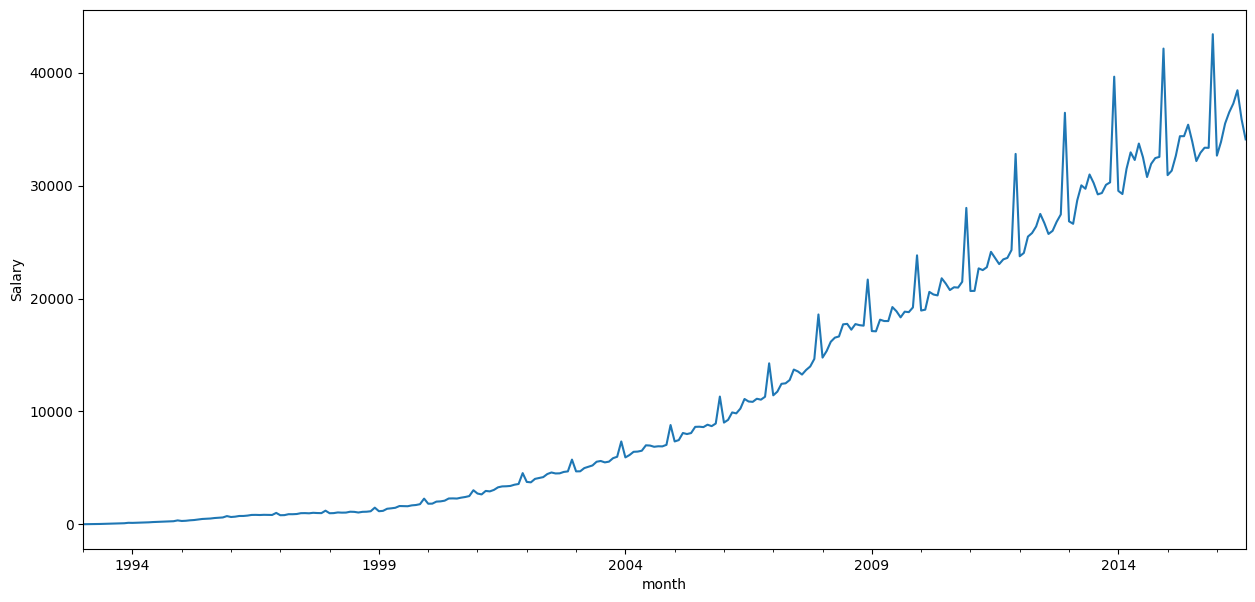

In [2]:
data = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary = data['WAG_C_M']
plt.figure(figsize(15,7))
salary.plot()
plt.ylabel('Salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1500x1000 with 0 Axes>

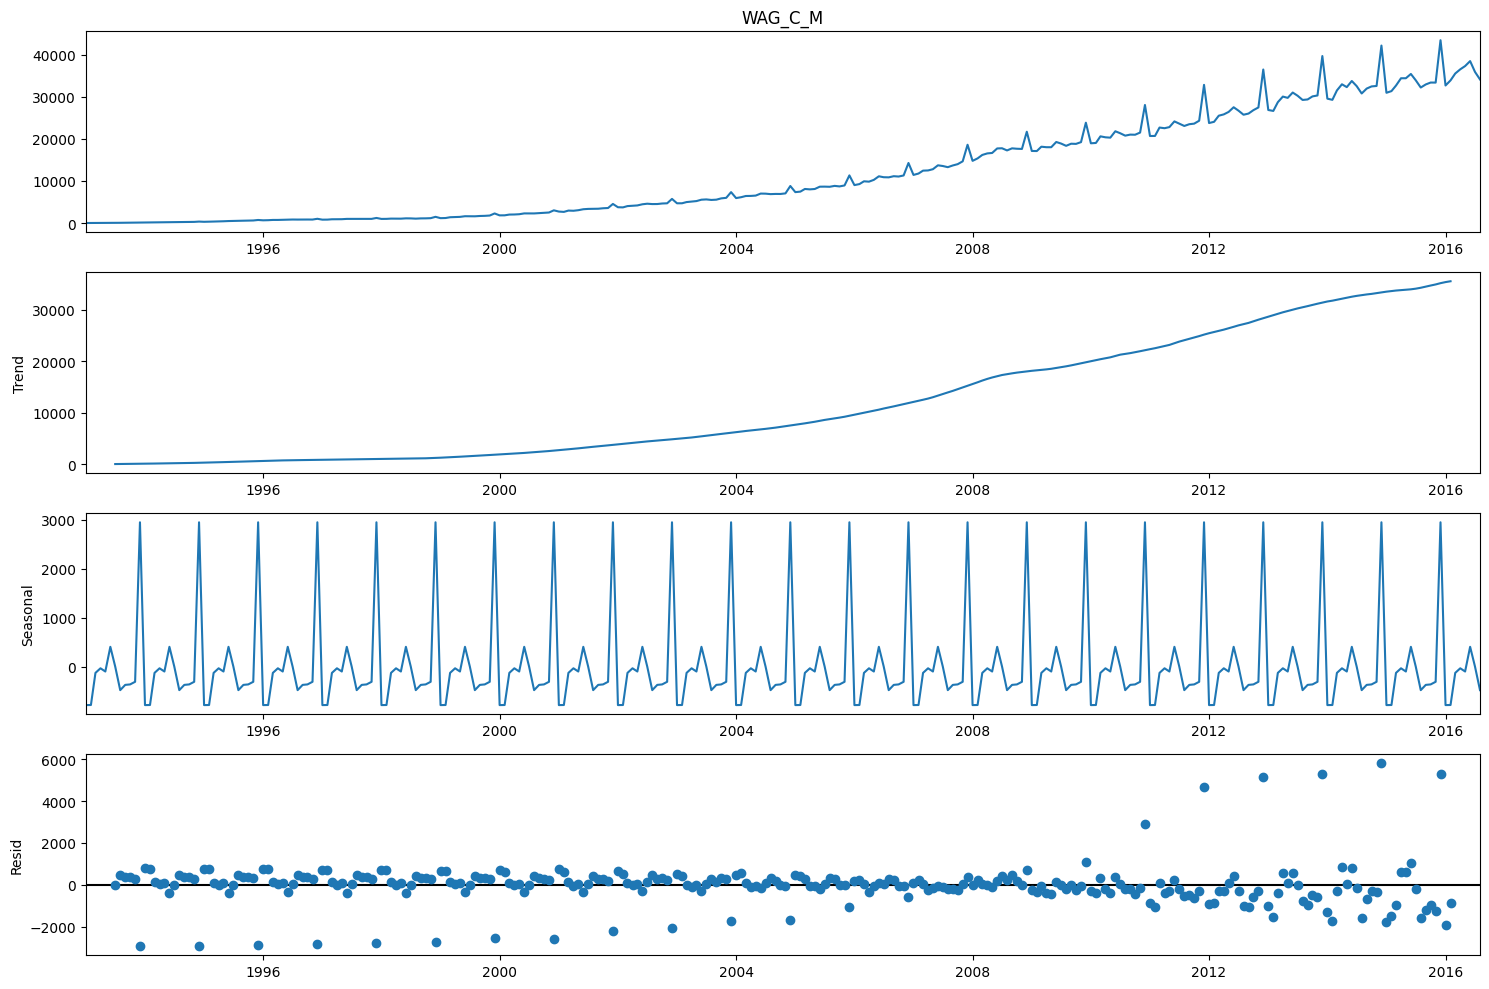

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


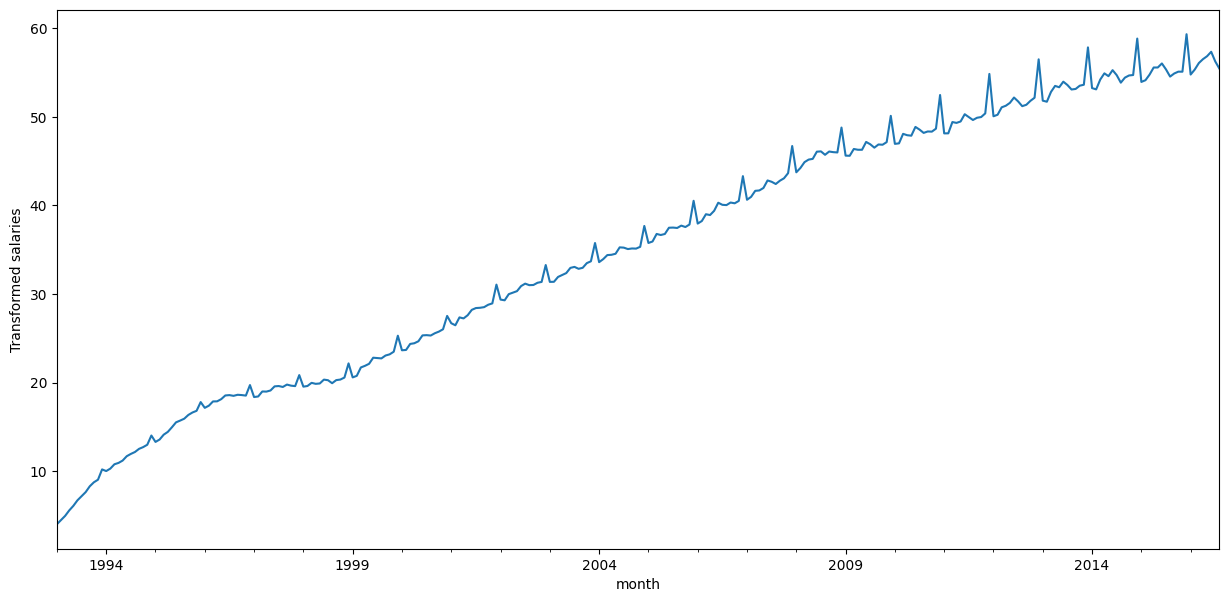

In [4]:
data['box'], lmbda = stats.boxcox(salary)
plt.figure(figsize(15,7))
data.box.plot()
plt.ylabel(u'Transformed salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1500x1000 with 0 Axes>

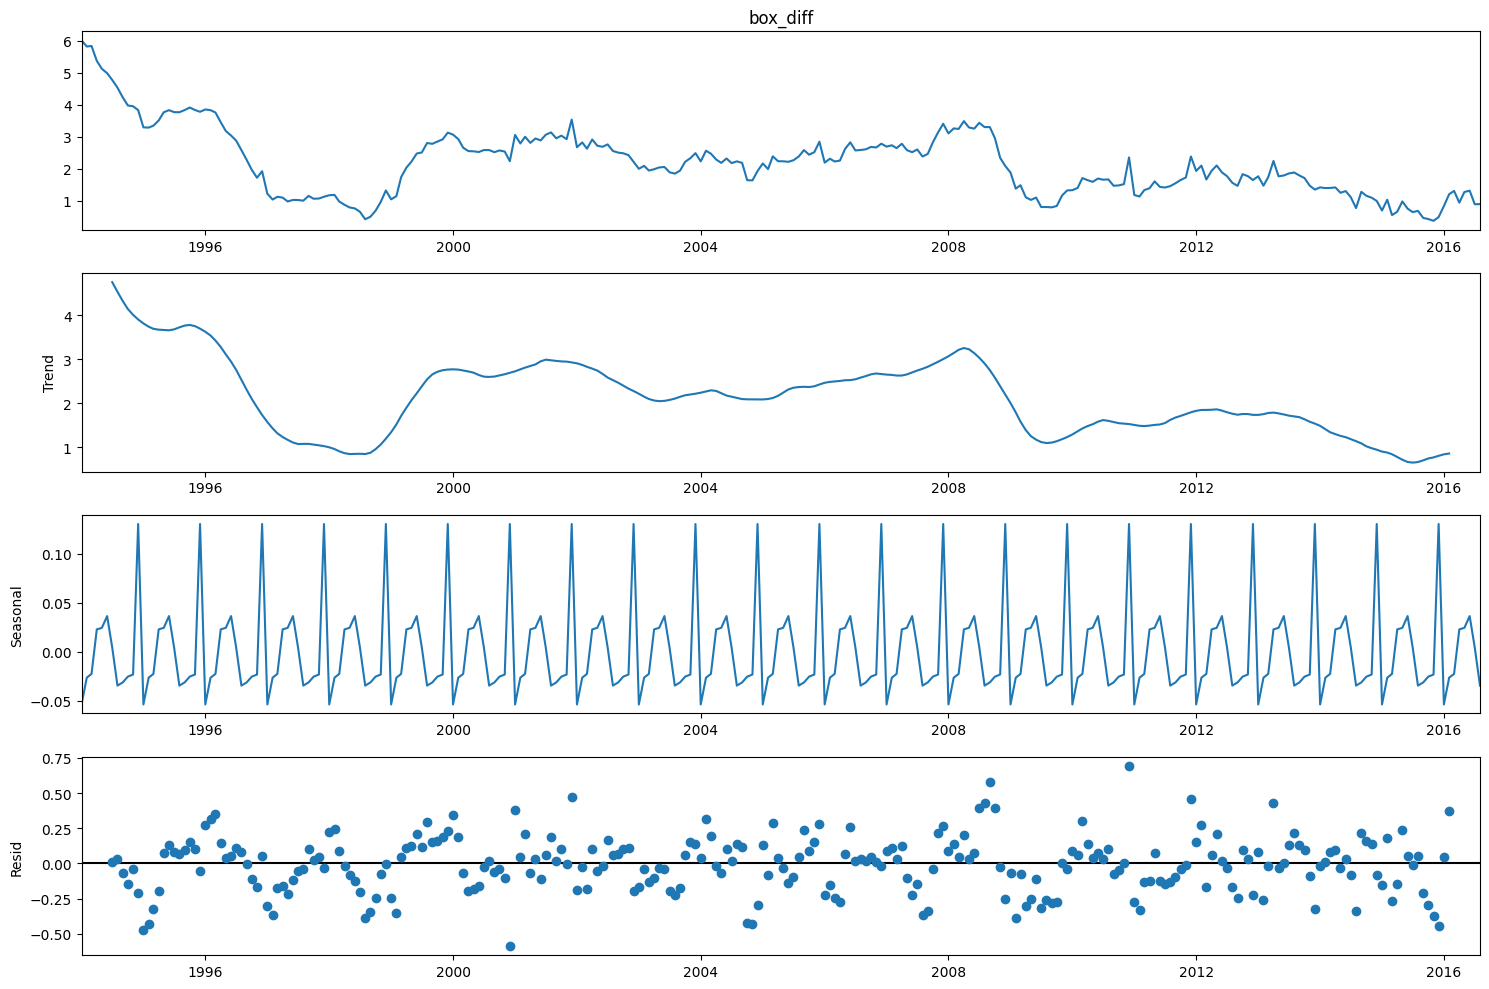

In [5]:
data['box_diff'] = data.box - data.box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1500x1000 with 0 Axes>

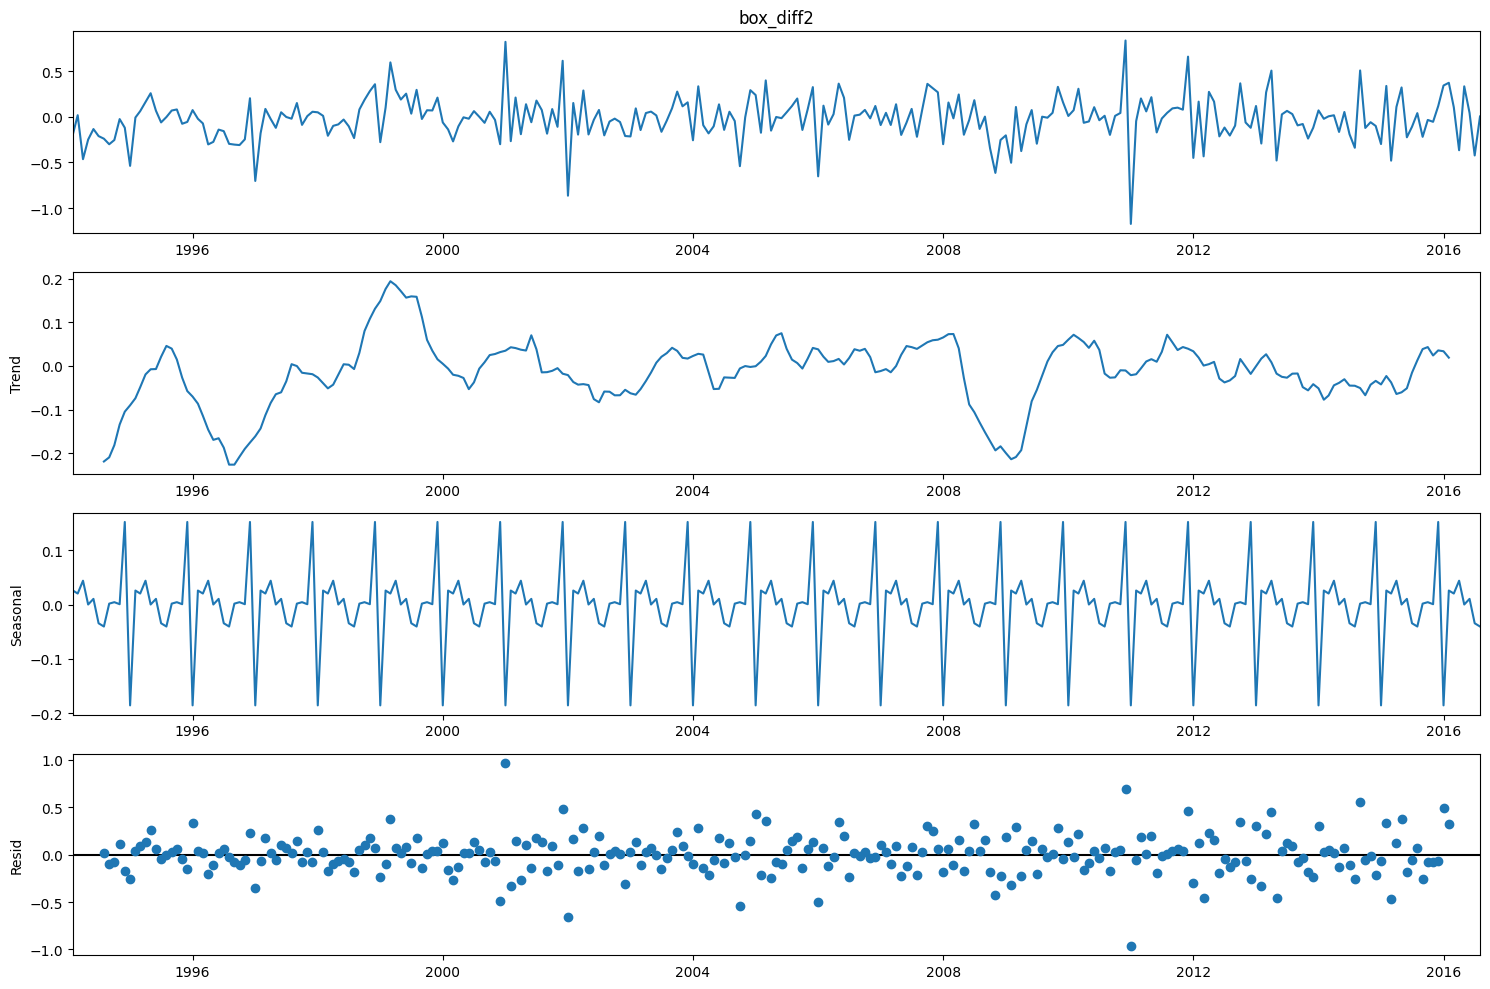

In [6]:
data['box_diff2'] = data.box_diff - data.box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

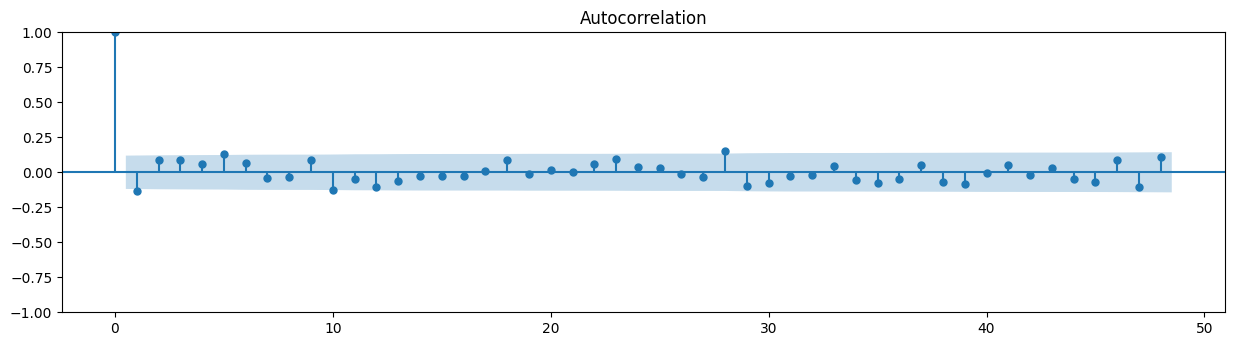

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


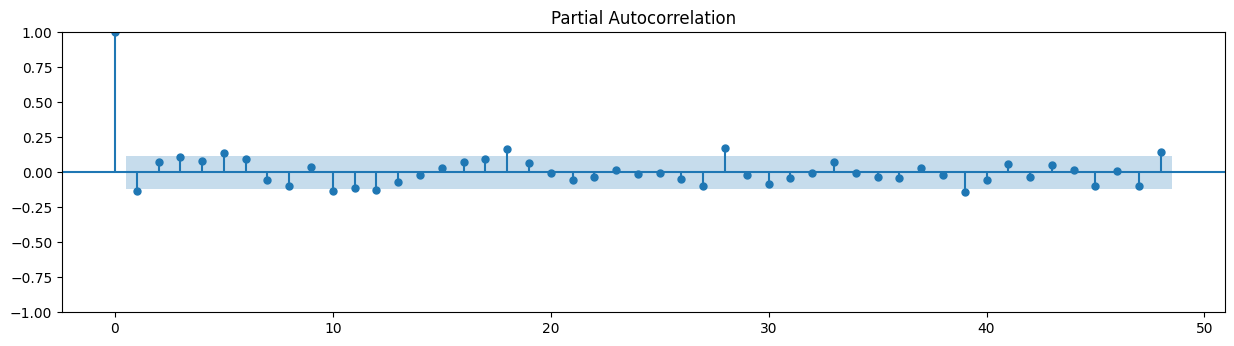

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=2, p=2

In [10]:
qs = range(0, 2)
Qs = range(0, 1)

ps = range(0, 2)
Ps = range(0, 2)

d = 1
D = 1 

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 2.3 s, sys: 1.6 s, total: 3.9 s
Wall time: 6.3 s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Лучшая модель:

In [14]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sun, 04 Jun 2023   AIC                              0.341
Time:                                    04:35:53   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Её остатки:

Критерий Стьюдента: p=0.090795
Критерий Дики-Фуллера: p=0.000003


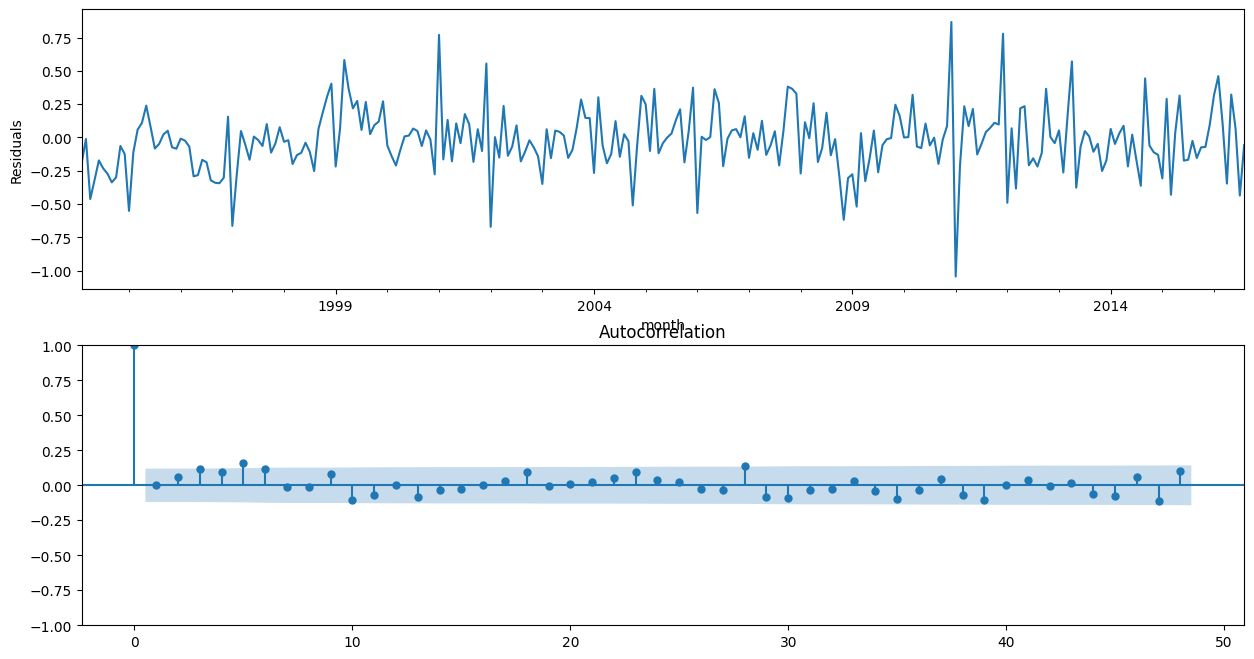

In [15]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


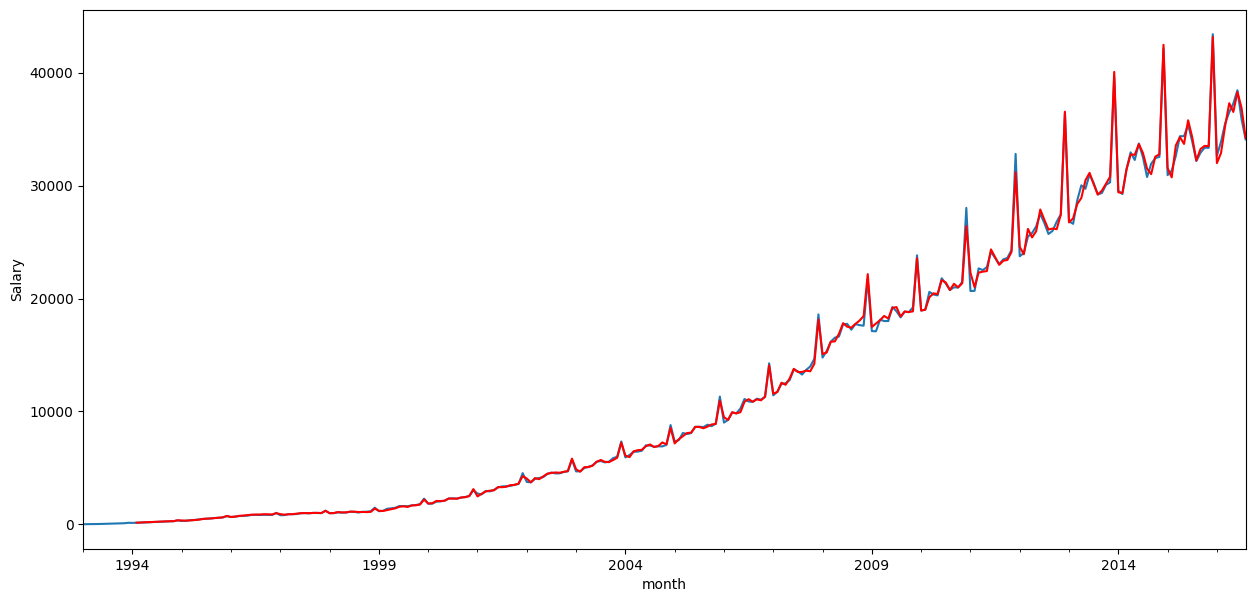

In [16]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.plot()
data.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

### Прогноз

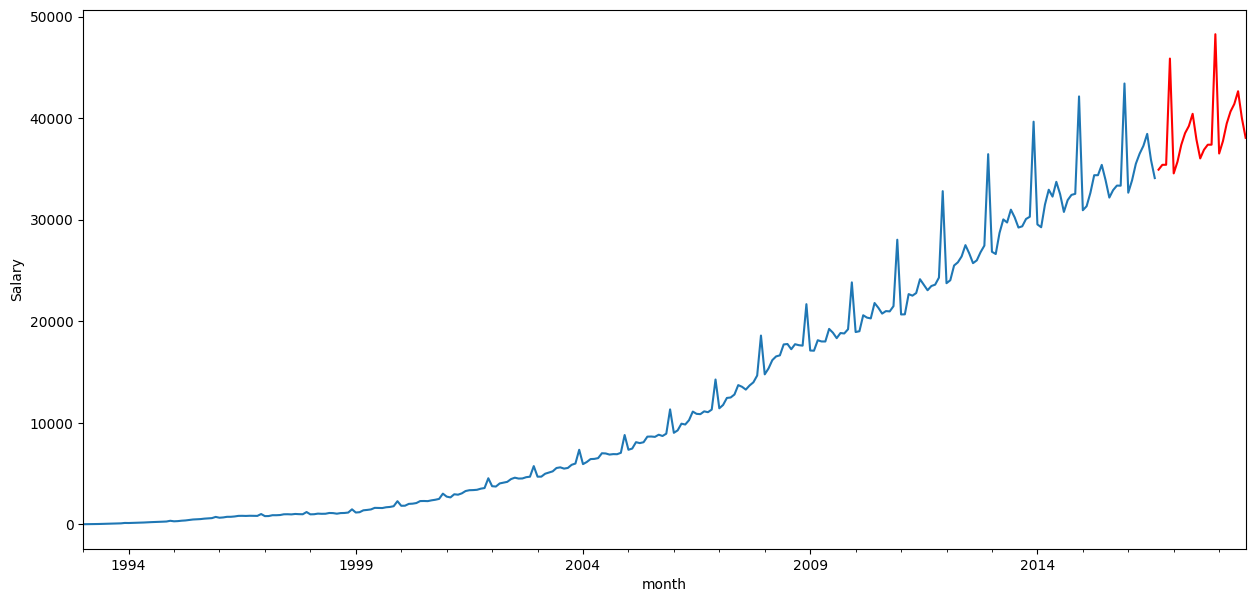

In [21]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
salary.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

In [22]:
real_data = pd.DataFrame({
    "month": [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)],
    "WAG_C_M": [
        35843.0, 35749.0, 36195.0, 47554.0, 34422.0, 35497.0, 37899.0, 39225.0, 39679.0, 41454.0, 38073.0, 37099.0,
        38047.0, 38333.0, 38848.0, 51197.0, 39017.0, 40443.0, 42364.0, 43381.0, 44076.0, 45848.0, 42413.0, 41364.0
    ],
})
real_data

,month,WAG_C_M
0,2016-09-01,35843.0
1,2016-10-01,35749.0
2,2016-11-01,36195.0
3,2016-12-01,47554.0
4,2017-01-01,34422.0
5,2017-02-01,35497.0
6,2017-03-01,37899.0
7,2017-04-01,39225.0
8,2017-05-01,39679.0
9,2017-06-01,41454.0


In [19]:
real_data.to_csv("real_data.csv", index=False)

In [29]:
real_data = pd.read_csv("real_data.csv", index_col=['month'], parse_dates=['month'], dayfirst=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


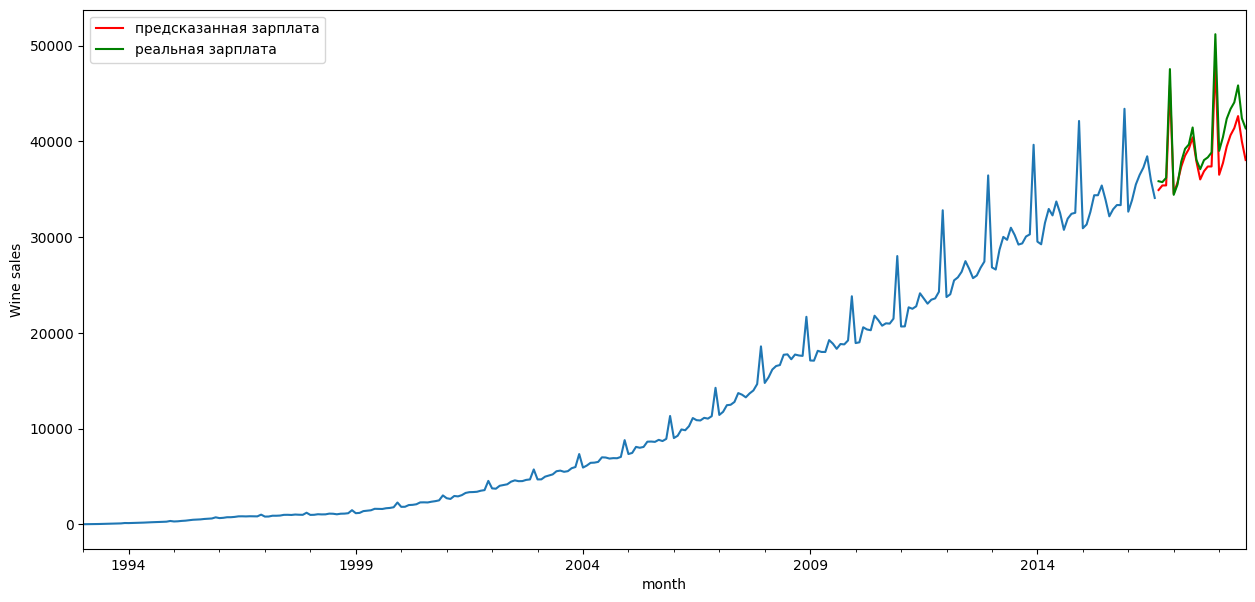

In [31]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot(label='')
data2.forecast.plot(color='r', label='предсказанная зарплата')
real_data.WAG_C_M.plot(color='g', label='реальная зарплата')
plt.ylabel('Wine sales')
plt.legend()
pylab.show()

In [43]:
data2['real_data'] = real_data['WAG_C_M']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WAG_C_M,forecast,real_data
1993-01-01,15.3,NaN,NaN
1993-02-01,19.1,NaN,NaN
1993-03-01,23.6,NaN,NaN
1993-04-01,30.6,NaN,NaN
1993-05-01,37.5,NaN,NaN
...,...,...,...
2018-04-01,NaN,40646.452427,43381.0
2018-05-01,NaN,41387.344242,44076.0
2018-06-01,NaN,42646.077678,45848.0
2018-07-01,NaN,40000.823216,42413.0


In [45]:
data2[['forecast', 'real_data']][-24:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,forecast,real_data
2016-09-01,34923.434480,35843.0
2016-10-01,35400.094167,35749.0
2016-11-01,35405.939392,36195.0
2016-12-01,45863.047123,47554.0
2017-01-01,34554.766586,34422.0
2017-02-01,35708.458155,35497.0
2017-03-01,37368.662081,37899.0
2017-04-01,38517.859667,39225.0
2017-05-01,39216.114175,39679.0
2017-06-01,40424.245784,41454.0


### Метрики

In [46]:
def print_metrics(actual, forecast):
    print("-"*50)
    print("* R^2:", 1 - np.sum((actual-forecast)**2) / np.sum((actual - np.mean(actual))**2))
    print("* MSE:", np.mean((actual-forecast)**2))
    print("* RMSE:", np.sqrt(np.mean((actual-forecast)**2)))
    print("* MAE:", np.mean(np.abs(actual-forecast)))
    print("* MAPE: ", np.mean(np.abs(actual-forecast) / np.abs(actual)) * 100, "%", sep='')
    print("-"*50)

In [47]:
forecast = data2['forecast'].dropna().astype(int).values
actual = data2['real_data'].dropna().astype(int).values

print("Прогноз:", forecast)
print("Актуальные данные:", actual)

print_metrics(actual, forecast)

Прогноз: [34923 35400 35405 45863 34554 35708 37368 38517 39216 40424 37899 36031
 36885 37380 37384 48259 36516 37733 39466 40646 41387 42646 40000 38056]
Актуальные данные: [35843 35749 36195 47554 34422 35497 37899 39225 39679 41454 38073 37099
 38047 38333 38848 51197 39017 40443 42364 43381 44076 45848 42413 41364]
--------------------------------------------------
* R^2: 0.7816125636288822
* MSE: 3520975.0833333335
* RMSE: 1876.4261465171853
* MAE: 1543.3333333333333
* MAPE: 3.6886562566574668%
--------------------------------------------------


# Часть 2

In [114]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [115]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

### Подготовка данных

In [116]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [117]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [118]:
data = pd.read_csv('WAG_C_M.csv', ';')

<ipython-input-118-883c7c04dd82>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv('WAG_C_M.csv', ';')


In [119]:
test_data = pd.read_csv("real_data.csv")

In [120]:
x_train = data['WAG_C_M'].to_numpy()
x_test = test_data['WAG_C_M'].to_numpy()

time_train = np.arange(len(x_train), dtype="float32")
time_test = np.arange(len(x_train), len(x_train) + len(x_test), dtype="float32")

In [121]:
series = np.concatenate([x_train, x_test])

In [122]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [123]:
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


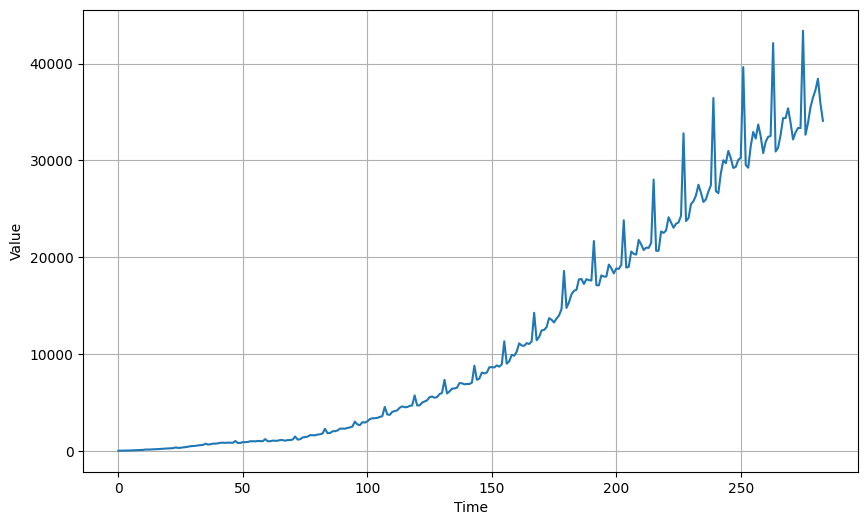

In [124]:
plot_series(time_train, x_train)

### Однослойный перцептрон

In [125]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.21340609],
       [ 0.43250555],
       [ 0.15670621],
       [-0.11846447],
       [ 0.50214964],
       [-0.01356661],
       [-0.17841816],
       [-0.31117582],
       [-0.3972389 ],
       [-0.04832986],
       [-0.2519414 ],
       [ 0.43625957],
       [-0.24050876],
       [ 0.53196174],
       [ 0.11019909],
       [ 0.4451049 ],
       [ 0.46504915],
       [ 0.4902975 ],
       [-0.07227483],
       [-0.466523  ]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [126]:
model.compile(loss="mae", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [127]:
model.fit(dataset,epochs=100)

Epoch 1/100
9/9 [==============================] - 0s 5ms/step - loss: 2244.9778
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 3324.4441
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 1980.4741
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 1865.8240
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 1472.6542
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 1275.8499
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 1291.1322
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 1588.8563
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 2182.6865
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 1466.6804
Epoch 11/100
9/9 [==============================] - 0s 2ms/step - loss: 1599.4625
Epoch 12/100
9/9 [==============================] - 0s 3ms/step - loss: 1316.1948
Epoch 13/100
9/9 [=======

In [128]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-7.6621629e-02],
       [ 1.3954937e-04],
       [ 1.4787684e-01],
       [-1.9400811e-01],
       [ 1.1629340e-01],
       [-2.9104477e-01],
       [-1.9607334e-01],
       [-1.5685518e-01],
       [ 6.6795826e-01],
       [-2.6673549e-01],
       [-2.4945709e-01],
       [-2.7290143e-02],
       [ 1.5104900e-01],
       [ 2.4064000e-01],
       [ 2.7395582e-01],
       [ 4.7910136e-01],
       [ 1.3509381e-01],
       [ 3.4287286e-01],
       [ 1.0508511e-01],
       [-1.2683151e-03]], dtype=float32), array([0.00055405], dtype=float32)]


In [129]:
# Shape of the first 20 data points slice
print(f'shape of series[0:{window_size}]: {series[0:window_size].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:{window_size}][np.newaxis]: {series[0:window_size][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:{window_size}][np.newaxis]: {np.expand_dims(series[0:window_size], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:window_size][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 51ms/step
model prediction: [[267.0389]]


In [130]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[len(x_train) - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_test.shape}')

1/1 [==============================] - 0s 23ms/step
length of the forecast list: 24
shape of the validation set: (24,)


shape after converting to numpy array: (24, 1, 1)
shape after squeezing: (24,)


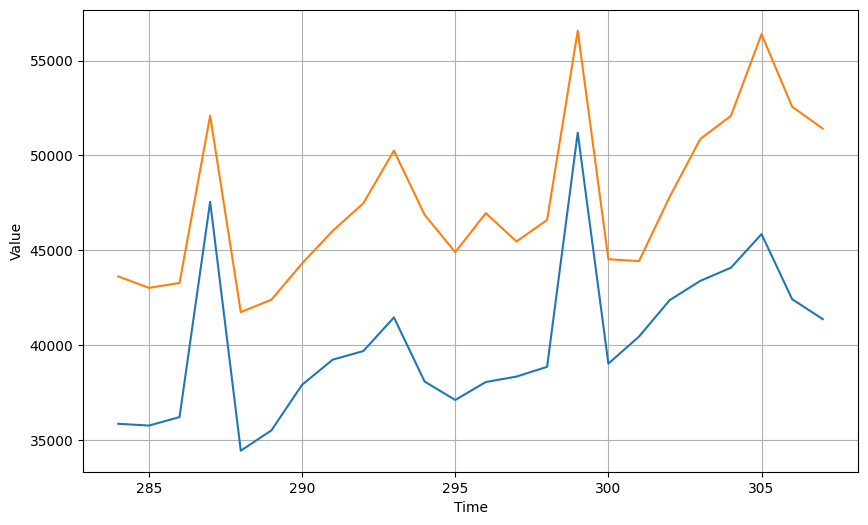

In [131]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_test, (x_test, results))

In [132]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_test, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, results).numpy())

57459724.0
7400.018


<ipython-input-134-fa2e8fa0810b>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  merged_data = pd.read_csv('WAG_C_M.csv', ';').append(pd.read_csv('real_data.csv'), ignore_index=True)
<ipython-input-134-fa2e8fa0810b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = pd.read_csv('WAG_C_M.csv', ';').append(pd.read_csv('real_data.csv'), ignore_index=True)


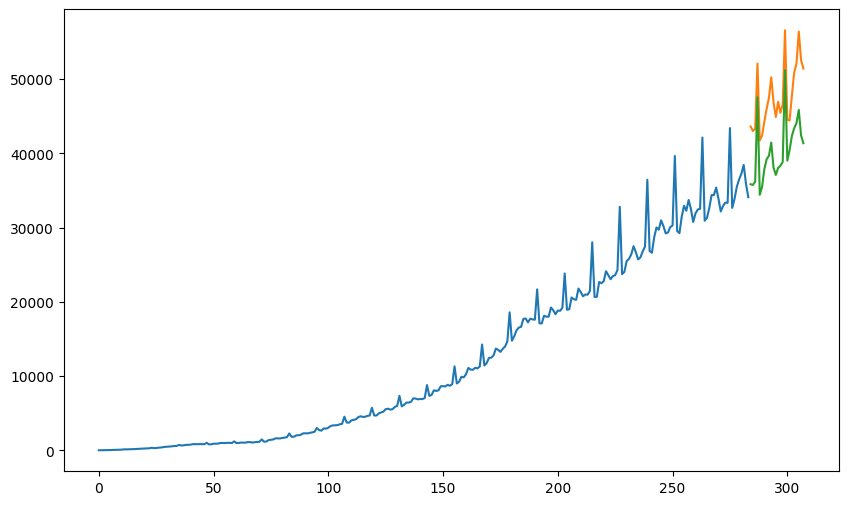

In [134]:
merged_data = pd.read_csv('WAG_C_M.csv', ';').append(pd.read_csv('real_data.csv'), ignore_index=True)

plt.figure(figsize=(10, 6))
plt.plot(data.index, data.WAG_C_M)
plt.plot(merged_data.index[-24:], results)
plt.plot(merged_data.index[-24:], merged_data.WAG_C_M[-24:])
plt.show()

### RNN

In [135]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_20 (Lambda)          (None, 20, 1)             0         
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 20, 40)            1680      
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dense_14 (Dense)            (None, 1)                 41        
                                                                 
 lambda_21 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [136]:
scaler = MinMaxScaler()
x_scaled =  scaler.fit_transform(np.array(merged_data['WAG_C_M']).reshape(-1, 1))
x_train_scaled = x_scaled[:data.shape[0]].reshape(-1, 1).squeeze()
x_valid_scaled = x_scaled[data.shape[0]:].reshape(-1, 1).squeeze()

In [137]:
dataset = windowed_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)

In [138]:
# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
9/9 [==============================] - 3s 14ms/step - loss: 31.3598 - mae: 31.8597
Epoch 2/100
9/9 [==============================] - 0s 12ms/step - loss: 19.5167 - mae: 20.0167
Epoch 3/100
9/9 [==============================] - 0s 14ms/step - loss: 16.9869 - mae: 17.4869
Epoch 4/100
9/9 [==============================] - 0s 15ms/step - loss: 15.5751 - mae: 16.0559
Epoch 5/100
9/9 [==============================] - 0s 12ms/step - loss: 13.8151 - mae: 14.3130
Epoch 6/100
9/9 [==============================] - 0s 16ms/step - loss: 11.3136 - mae: 11.8136
Epoch 7/100
9/9 [==============================] - 0s 12ms/step - loss: 10.2970 - mae: 10.7952
Epoch 8/100
9/9 [==============================] - 0s 12ms/step - loss: 8.8459 - mae: 9.3459
Epoch 9/100
9/9 [==============================] - 0s 11ms/step - loss: 7.1909 - mae: 7.6868
Epoch 10/100
9/9 [==============================] - 0s 11ms/step - loss: 6.3535 - mae: 6.8498
Epoch 11/100
9/9 [==============================] - 0s 

In [139]:
forecast = []

for time in range(len(x_scaled) - window_size):
  forecast.append(model.predict(x_scaled[time:time + window_size][np.newaxis]))

forecast = forecast[len(x_train_scaled) - window_size:]

1/1 [==============================] - 0s 25ms/step


In [140]:
results = scaler.inverse_transform(np.array(forecast).squeeze().reshape(-1, 1)).squeeze()

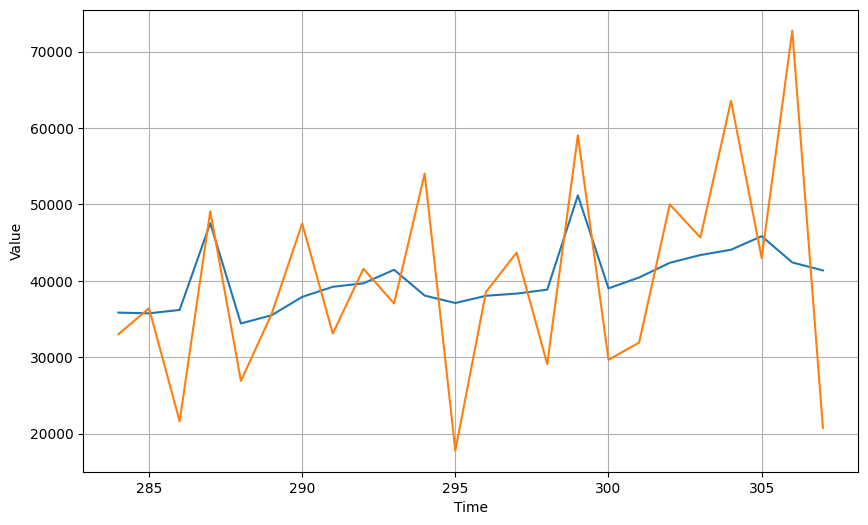

In [141]:
plot_series(time_test, (x_test, results))

In [142]:
print(tf.keras.metrics.mean_squared_error(x_test, results[-24:]).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, results[-24:]).numpy())

133533980.0
8718.214


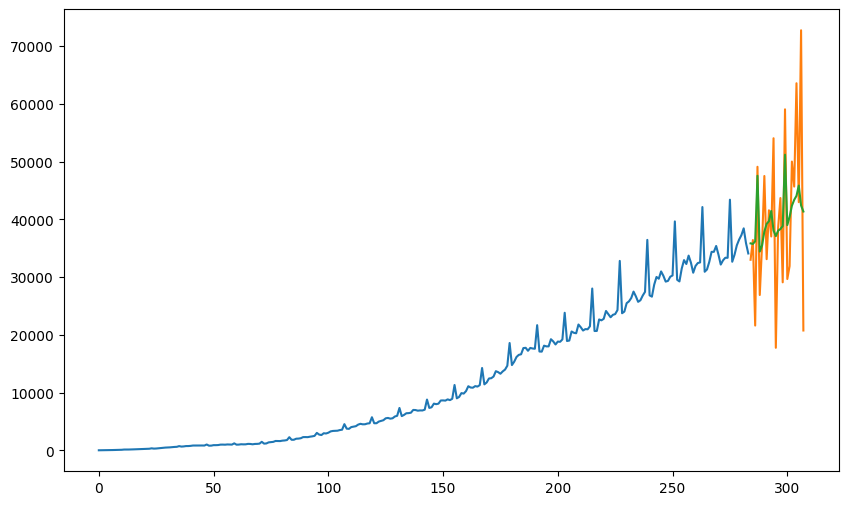

In [143]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data.WAG_C_M)
plt.plot(merged_data.index[-24:], results[-24:])
plt.plot(merged_data.index[-24:], merged_data.WAG_C_M[-24:])
plt.show()

### LSTM

In [144]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_22 (Lambda)          (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
 lambda_23 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-tra

In [145]:
data = pd.read_csv('WAG_C_M.csv', ';')
merged_data = pd.read_csv('WAG_C_M.csv', ';').append(pd.read_csv('real_data.csv'), ignore_index=True)

<ipython-input-145-b4072a6f67fa>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv('WAG_C_M.csv', ';')
<ipython-input-145-b4072a6f67fa>:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  merged_data = pd.read_csv('WAG_C_M.csv', ';').append(pd.read_csv('real_data.csv'), ignore_index=True)
<ipython-input-145-b4072a6f67fa>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = pd.read_csv('WAG_C_M.csv', ';').append(pd.read_csv('real_data.csv'), ignore_index=True)


In [146]:
scaler = MinMaxScaler()
x_scaled =  scaler.fit_transform(np.array(merged_data['WAG_C_M']).reshape(-1, 1))
x_train_scaled = x_scaled[:data.shape[0]].reshape(-1, 1).squeeze()
x_valid_scaled = x_scaled[data.shape[0]:].reshape(-1, 1).squeeze()

In [147]:
dataset = windowed_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)

In [148]:
# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Train the model
history = model.fit(dataset, epochs=100)

Epoch 1/100
9/9 [==============================] - 14s 80ms/step - loss: 3.0784 - mae: 3.5491
Epoch 2/100
9/9 [==============================] - 1s 98ms/step - loss: 3.1949 - mae: 3.6949
Epoch 3/100
9/9 [==============================] - 1s 69ms/step - loss: 3.0113 - mae: 3.5113
Epoch 4/100
9/9 [==============================] - 1s 68ms/step - loss: 2.7266 - mae: 3.2266
Epoch 5/100
9/9 [==============================] - 1s 75ms/step - loss: 2.5378 - mae: 3.0378
Epoch 6/100
9/9 [==============================] - 1s 75ms/step - loss: 2.1554 - mae: 2.6521
Epoch 7/100
9/9 [==============================] - 1s 74ms/step - loss: 1.9788 - mae: 2.4506
Epoch 8/100
9/9 [==============================] - 1s 66ms/step - loss: 2.0958 - mae: 2.5958
Epoch 9/100
9/9 [==============================] - 1s 90ms/step - loss: 1.9004 - mae: 2.3994
Epoch 10/100
9/9 [==============================] - 1s 98ms/step - loss: 1.9050 - mae: 2.4050
Epoch 11/100
9/9 [==============================] - 1s 79ms/step - l

In [149]:
forecast = []

for time in range(len(x_scaled) - window_size):
  forecast.append(model.predict(x_scaled[time:time + window_size][np.newaxis]))

forecast = forecast[len(x_train_scaled) - window_size:]

1/1 [==============================] - 0s 27ms/step


In [150]:
results = scaler.inverse_transform(np.array(forecast).squeeze().reshape(-1, 1)).squeeze()

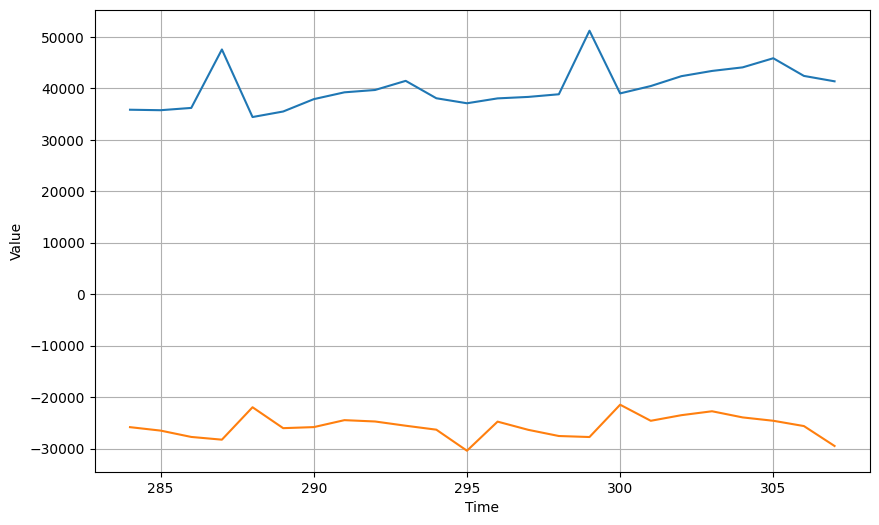

In [151]:
plot_series(time_test, (x_test, results))

In [153]:
print(tf.keras.metrics.mean_squared_error(x_test, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, results).numpy())

4358233600.0
65850.5


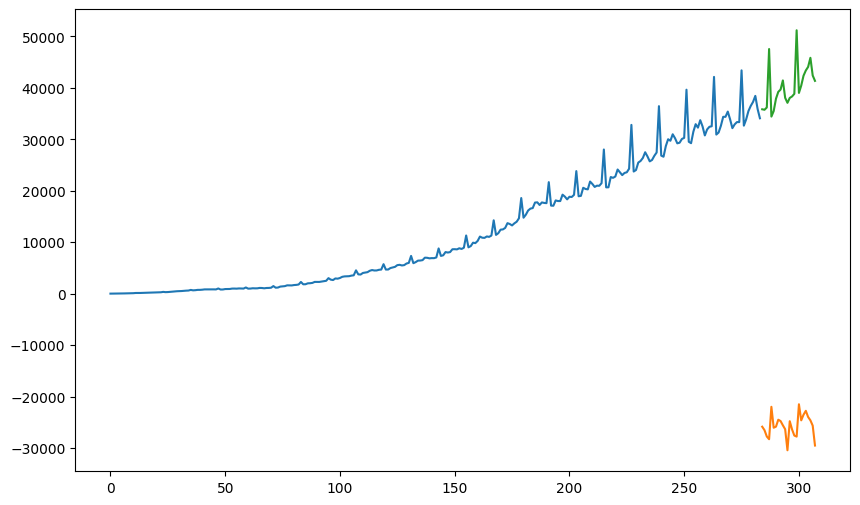

In [152]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data.WAG_C_M)
plt.plot(merged_data.index[-24:], results)
plt.plot(merged_data.index[-24:], merged_data.WAG_C_M[-24:])
plt.show()

### Conv + LSTM

In [154]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


In [155]:
data = pd.read_csv('WAG_C_M.csv', ';')
merged_data = pd.read_csv('WAG_C_M.csv', ';').append(pd.read_csv('real_data.csv'), ignore_index=True)

<ipython-input-155-b4072a6f67fa>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv('WAG_C_M.csv', ';')
<ipython-input-155-b4072a6f67fa>:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  merged_data = pd.read_csv('WAG_C_M.csv', ';').append(pd.read_csv('real_data.csv'), ignore_index=True)
<ipython-input-155-b4072a6f67fa>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = pd.read_csv('WAG_C_M.csv', ';').append(pd.read_csv('real_data.csv'), ignore_index=True)


In [156]:
scaler = MinMaxScaler()
x_scaled =  scaler.fit_transform(np.array(merged_data['WAG_C_M']).reshape(-1, 1))
x_train_scaled = x_scaled[:data.shape[0]].reshape(-1, 1).squeeze()
x_valid_scaled = x_scaled[data.shape[0]:].reshape(-1, 1).squeeze()

In [157]:
# Generate the dataset windows
dataset = windowed_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)

In [158]:
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Train the model
history = model.fit(dataset, epochs=100)

Epoch 1/100
9/9 [==============================] - 5s 35ms/step - loss: 4.1371 - mae: 4.6183
Epoch 2/100
9/9 [==============================] - 0s 38ms/step - loss: 2.7328 - mae: 3.2080
Epoch 3/100
9/9 [==============================] - 0s 38ms/step - loss: 0.9133 - mae: 1.3211
Epoch 4/100
9/9 [==============================] - 0s 33ms/step - loss: 0.1448 - mae: 0.4534
Epoch 5/100
9/9 [==============================] - 0s 31ms/step - loss: 0.1850 - mae: 0.5005
Epoch 6/100
9/9 [==============================] - 0s 33ms/step - loss: 0.0516 - mae: 0.2677
Epoch 7/100
9/9 [==============================] - 0s 31ms/step - loss: 0.0517 - mae: 0.2572
Epoch 8/100
9/9 [==============================] - 0s 33ms/step - loss: 0.0397 - mae: 0.2399
Epoch 9/100
9/9 [==============================] - 0s 40ms/step - loss: 0.0356 - mae: 0.2340
Epoch 10/100
9/9 [==============================] - 1s 57ms/step - loss: 0.0351 - mae: 0.2304
Epoch 11/100
9/9 [==============================] - 1s 57ms/step - lo

In [159]:
forecast = []

for time in range(len(x_scaled) - window_size):
  forecast.append(model.predict(x_scaled[time:time + window_size][np.newaxis]))

forecast = forecast[len(x_train_scaled) - window_size:]

1/1 [==============================] - 0s 28ms/step


In [160]:
results = scaler.inverse_transform(np.array(forecast).squeeze().reshape(-1, 1)).squeeze()

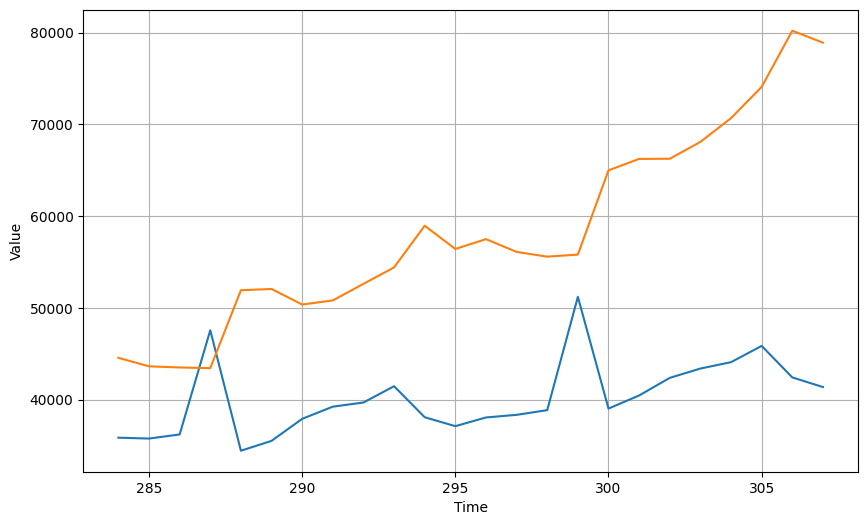

In [161]:
plot_series(time_test, (x_test, results))

In [162]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_test, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_test, results).numpy())

419968540.0
18385.24


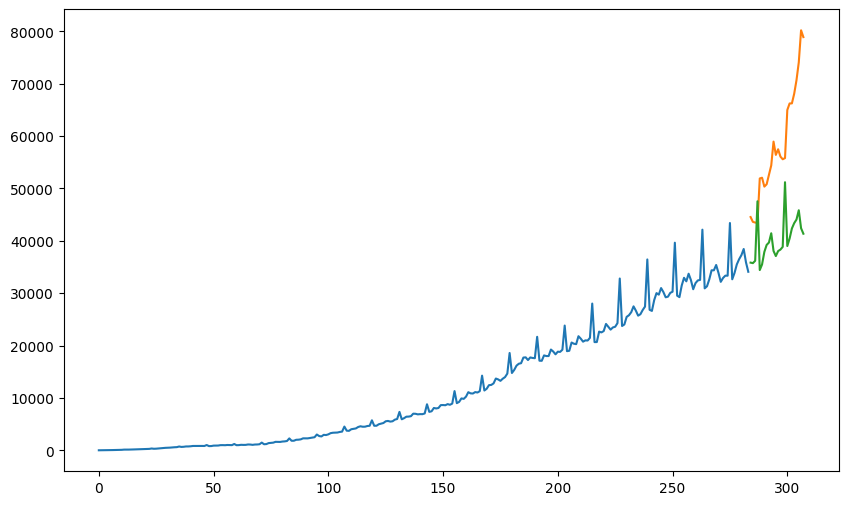

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data.WAG_C_M)
plt.plot(merged_data.index[-24:], results)
plt.plot(merged_data.index[-24:], merged_data.WAG_C_M[-24:])
plt.show()